<a href="https://colab.research.google.com/github/Arush0113/EEG_Pipeline-IITR/blob/main/Model_Subclassing_and_Custom_Training_Loops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


# Model subclassing and custom training loops

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***
<a id="coding_tutorial_4"></a>
## Custom training loops

#### Build the model

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [54]:
# Define the custom layers and model

class MyLayer(Layer):

  def __init__(self, units):
    super(MyLayer, self).__init__()
    self.units = units

  def build(self, input_shape):
    self.w = self.add_weight(shape = (input_shape[-1], self.units),
                             initializer = 'random_normal',
                             name = 'kernel')
    self.b = self.add_weight(shape = (self.units, ),
                             initializer = 'zeros',
                             name = 'bias')
    
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b


class MyDropout(Layer):

  def __init__(self, rate):
    super(MyDropout, self).__init__()
    self.rate = rate

  def call(self, inputs):
    return tf.nn.dropout(inputs, rate = self.rate)


class MyModel(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass

        x = self.layer_1(inputs)
        x=  tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x=  tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)

        return self.softmax(x)

In [55]:
model = MyModel(64, 64, 46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.00854835 0.01714355 0.05035708 0.06865607 0.00979114 0.01746842
  0.00638121 0.02538123 0.01147434 0.01758486 0.02422162 0.01842161
  0.00698514 0.00692308 0.03191622 0.01504221 0.0237428  0.00851432
  0.00638613 0.06181356 0.00507591 0.01809203 0.01509052 0.00608736
  0.00898348 0.02952386 0.01223031 0.06198739 0.04733888 0.02301822
  0.04100329 0.03587511 0.00507103 0.01857984 0.00982639 0.01775007
  0.03865208 0.00178042 0.00449873 0.02311325 0.00849572 0.01873134
  0.05838183 0.01507934 0.03180573 0.0071749 ]], shape=(1, 46), dtype=float32)
Model: "my_model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_11 (MyLayer)        multiple                  640064    
_________________________________________________________________
my_dropout_6 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_12 (MyLay

#### Load the reuters dataset and define the class_names 

In [56]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [57]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [58]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()
invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

In [59]:
# Print the first data example sentence

text_news

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

#### Preprocess the data

In [60]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
x_train[0]

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


array([0., 1., 1., ..., 0., 0., 0.])

In [61]:
# output = np.zeros((len(sample_data), 10000))
# sample_data = train_data[:20]
# # print(output)
# for i, word in enumerate(sample_data):
#   # print(word)
#   output[i, word] = 1
# output.shape

#### Define the loss function and optimizer



In [62]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [63]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [64]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical
import time

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensors((x_train, train_labels))
train_dataset = train_dataset.batch(32)

train_loss_results = []
train_accuracy_results = []

n_epochs = 30
weight_decay = 0.005

for epoch in range(n_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

  for x, y in train_dataset:
    loss_value, grads = grad(model, x, y, weight_decay)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    epoch_loss_avg(loss_value)
    epoch_accuracy(to_categorical(y), model(x))

  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  print("Epoch {:03d}: Loss {:.3f}: Accuracy {:.3%}".format(
      epoch,
      epoch_loss_avg.result(),
      epoch_accuracy.result()
  ))
    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch 000: Loss 11.936: Accuracy 3.707%
Epoch 001: Loss 11.671: Accuracy 6.513%
Epoch 002: Loss 11.413: Accuracy 10.310%
Epoch 003: Loss 11.158: Accuracy 13.872%
Epoch 004: Loss 10.909: Accuracy 17.591%
Epoch 005: Loss 10.666: Accuracy 20.029%
Epoch 006: Loss 10.424: Accuracy 23.614%
Epoch 007: Loss 10.191: Accuracy 24.749%
Epoch 008: Loss 9.958: Accuracy 26.820%
Epoch 009: Loss 9.724: Accuracy 27.711%
Epoch 010: Loss 9.497: Accuracy 28.379%
Epoch 011: Loss 9.269: Accuracy 29.036%
Epoch 012: Loss 9.040: Accuracy 29.181%
Epoch 013: Loss 8.816: Accuracy 29.659%
Epoch 014: Loss 8.585: Accuracy 29.871%
Epoch 015: Loss 8.361: Accuracy 30.450%
Epoch 016: Loss 8.139: Accuracy 30.428%
Epoch 017: Loss 7.919: Accuracy 31.418%
Epoch 018: Loss 7.711: Accuracy 30.572%
Epoch 019: Loss 7.497: Accuracy 31.051%
Epoch 020: Loss 7.296: Accuracy 32.320%
Epoch 021: Loss 7.107: Accuracy 33.434%
Epoch 022: Loss 6.934: Accuracy 32.999%
Epoch 023: Loss 6.765: Accuracy 33.589%
Epoch 024: Loss 6.596: Accuracy 34

#### Evaluate the model

In [65]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [66]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [67]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 5.717
Test accuracy: 39.492%


#### Plot the learning curves

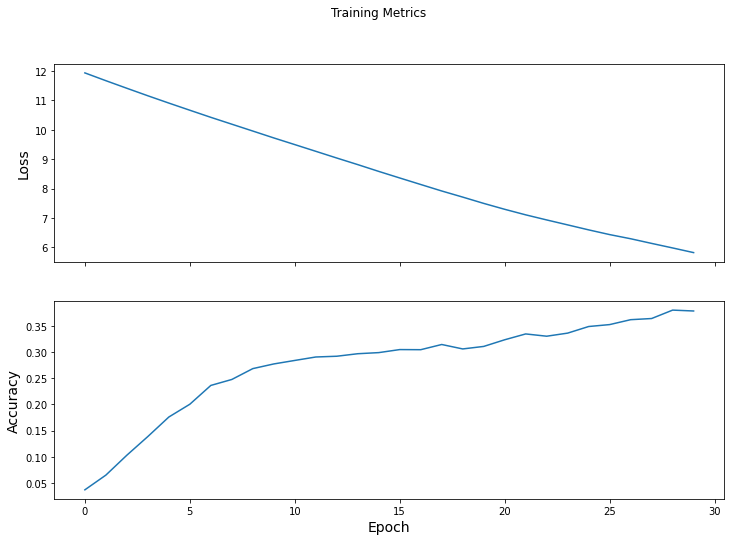

In [68]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [69]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: acq
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [70]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [71]:
# Initialize a new model

model = MyModel(64, 64, 46)

#### Redefine the grad function using the @tf.function decorator

In [72]:
# Use the @tf.function decorator

@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Train the model

In [73]:
# Re-run the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensors((x_train, train_labels))
train_dataset = train_dataset.batch(32)

train_loss_results = []
train_accuracy_results = []

n_epochs = 30
weight_decay = 0.005

for epoch in range(n_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

  for x, y in train_dataset:
    loss_value, grads = grad(model, x, y, weight_decay)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    epoch_loss_avg(loss_value)
    epoch_accuracy(to_categorical(y), model(x))

  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  print("Epoch {:03d}: Loss {:.3f}: Accuracy {:.3%}".format(
      epoch,
      epoch_loss_avg.result(),
      epoch_accuracy.result()
  ))
    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch 000: Loss 11.891: Accuracy 2.572%
Epoch 001: Loss 11.738: Accuracy 4.387%
Epoch 002: Loss 11.534: Accuracy 6.168%
Epoch 003: Loss 11.298: Accuracy 9.575%
Epoch 004: Loss 11.041: Accuracy 13.939%
Epoch 005: Loss 10.771: Accuracy 17.157%
Epoch 006: Loss 10.492: Accuracy 20.597%
Epoch 007: Loss 10.206: Accuracy 22.512%
Epoch 008: Loss 9.918: Accuracy 23.413%
Epoch 009: Loss 9.623: Accuracy 25.139%
Epoch 010: Loss 9.331: Accuracy 25.418%
Epoch 011: Loss 9.034: Accuracy 26.698%
Epoch 012: Loss 8.734: Accuracy 26.420%
Epoch 013: Loss 8.436: Accuracy 27.689%
Epoch 014: Loss 8.129: Accuracy 26.921%
Epoch 015: Loss 7.832: Accuracy 27.945%
Epoch 016: Loss 7.539: Accuracy 28.535%
Epoch 017: Loss 7.266: Accuracy 29.303%
Epoch 018: Loss 7.001: Accuracy 30.428%
Epoch 019: Loss 6.766: Accuracy 30.873%
Epoch 020: Loss 6.545: Accuracy 31.674%
Epoch 021: Loss 6.333: Accuracy 32.955%
Epoch 022: Loss 6.133: Accuracy 35.337%
Epoch 023: Loss 5.937: Accuracy 35.772%
Epoch 024: Loss 5.734: Accuracy 37.0

#### Print the autograph code

In [74]:
# Use tf.autograph.to_code to see the generated code

print(tf.autograph.to_code(grad.python_function))

def tf__grad(model, inputs, targets, wd):
    with ag__.FunctionScope('grad', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        with ag__.ld(tf).GradientTape() as tape:
            loss_value = ag__.converted_call(ag__.ld(loss), (ag__.ld(model), ag__.ld(inputs), ag__.ld(targets), ag__.ld(wd)), None, fscope)
        try:
            do_return = True
            retval_ = (ag__.ld(loss_value), ag__.converted_call(ag__.ld(tape).gradient, (ag__.ld(loss_value), ag__.ld(model).trainable_variables), None, fscope))
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

